# Проведения гипотезы с данными


---

Некоторые miRNA являются биомаркерами, связанными с прогрессией РПЖ, включая развитие метастазов в лимфатические узлы, и могут быть использованы для прогнозирования исходов заболевания.

---

Задачи:

1.Найти miRNA, дифференциально экспрессируемые при РПЖ (особенно при агрессивных формах).

2.Определить miRNA, коррелирующие с метастазированием в лимфатические узлы.

3.Подготовить список кандидатов для биоинформатического анализа.

In [26]:
# Установка библиотек
!pip install lifelines
!pip install fastcluster  # Устанавливаем fastcluster для улучшения производительности кластеризации

# Импорт библиотек
import pandas as pd
import numpy as np
from scipy.stats import mannwhitneyu, spearmanr
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [27]:
# Загрузка данных
clinical_df = pd.read_csv('clinical.tsv', sep='\t', index_col=0).T
mirna_df = pd.read_csv('mirna.tsv', sep='\t', index_col=0).T

# Объединение данных
mirna_data = mirna_df.merge(clinical_df, left_index=True, right_index=True, how='inner')
print(f"Общие образцы: {len(mirna_data.index)}")

# Список всех miRNA
mirnas = [col for col in mirna_df.columns if col.startswith('hsa-')]
print(f"Всего miRNA: {len(mirnas)}")

Общие образцы: 494
Всего miRNA: 765


In [28]:
# 1. Прогрессия РПЖ (T2 vs T3/T4)
print("\nАнализ прогрессии РПЖ (T2 vs T3/T4):")
t_stage_results = []
for mirna in mirnas:
    group_t2 = mirna_data[mirna_data['pathology_T_stage'] == 't2'][mirna].dropna()
    group_t3t4 = mirna_data[mirna_data['pathology_T_stage'].isin(['t3', 't4'])][mirna].dropna()

    if len(group_t2) > 1 and len(group_t3t4) > 1:
        stat, p_value = mannwhitneyu(group_t2, group_t3t4)
        mean_t2, mean_t3t4 = group_t2.mean(), group_t3t4.mean()
        fold_change = mean_t3t4 / mean_t2 if mean_t2 != 0 else float('inf')
        t_stage_results.append({
            'miRNA': mirna,
            'p_value': p_value,
            'fold_change': fold_change,
            'mean_t2': mean_t2,
            'mean_t3t4': mean_t3t4
        })


Анализ прогрессии РПЖ (T2 vs T3/T4):


In [29]:
# FDR-коррекция
t_stage_df = pd.DataFrame(t_stage_results)
p_values_t = t_stage_df['p_value'].values
_, pvals_corrected_t, _, _ = multipletests(p_values_t, method='fdr_bh')
t_stage_df['p_value_corrected'] = pvals_corrected_t
t_stage_significant = t_stage_df[t_stage_df['p_value_corrected'] < 0.05].sort_values('p_value_corrected')
print(f"Значимых miRNA для T2 vs T3/T4: {len(t_stage_significant)}")
print(t_stage_significant.head(10))

Значимых miRNA для T2 vs T3/T4: 76
              miRNA       p_value  fold_change    mean_t2  mean_t3t4  \
266     hsa-mir-30a  4.954418e-11     0.972648  15.119402  14.705856   
117  hsa-mir-133a-1  1.321647e-10     0.915909   6.893418   6.313740   
233     hsa-mir-222  1.011838e-09     0.917895   5.650622   5.186675   
423    hsa-mir-3676  5.364834e-09     0.681867   2.404073   1.639258   
232     hsa-mir-221  2.855485e-08     0.942119   7.587116   7.147964   
737    hsa-mir-891a  4.946613e-08     0.777434   2.275720   1.769222   
119    hsa-mir-133b  6.821375e-08     0.868881   4.211218   3.659047   
118  hsa-mir-133a-2  8.019272e-08     0.806406   2.439678   1.967371   
226     hsa-mir-217  9.301365e-08     1.155167   3.815449   4.407482   
651     hsa-mir-582  2.287020e-07     0.947516   9.118777   8.640189   

     p_value_corrected  
266       3.790130e-08  
117       5.055301e-08  
233       2.580186e-07  
423       1.026024e-06  
232       4.368893e-06  
737       6.306932e-06

In [30]:
# 2. Метастазы в лимфатические узлы (n0 vs n1 и корреляция с number_of_lymph_nodes)
print("\nАнализ метастазов (n0 vs n1):")
n_stage_results = []
for mirna in mirnas:
    group_n0 = mirna_data[mirna_data['pathology_N_stage'] == 'n0'][mirna].dropna()
    group_n1 = mirna_data[mirna_data['pathology_N_stage'] == 'n1'][mirna].dropna()

    if len(group_n0) > 1 and len(group_n1) > 1:
        stat, p_value = mannwhitneyu(group_n0, group_n1)
        mean_n0, mean_n1 = group_n0.mean(), group_n1.mean()
        fold_change = mean_n1 / mean_n0 if mean_n0 != 0 else float('inf')
        n_stage_results.append({
            'miRNA': mirna,
            'p_value': p_value,
            'fold_change': fold_change,
            'mean_n0': mean_n0,
            'mean_n1': mean_n1
        })

# FDR-коррекция
n_stage_df = pd.DataFrame(n_stage_results)
p_values_n = n_stage_df['p_value'].values
_, pvals_corrected_n, _, _ = multipletests(p_values_n, method='fdr_bh')
n_stage_df['p_value_corrected'] = pvals_corrected_n
n_stage_significant = n_stage_df[n_stage_df['p_value_corrected'] < 0.05].sort_values('p_value_corrected')
print(f"Значимых miRNA для n0 vs n1: {len(n_stage_significant)}")
print(n_stage_significant.head(10))


Анализ метастазов (n0 vs n1):
Значимых miRNA для n0 vs n1: 22
              miRNA   p_value  fold_change    mean_n0    mean_n1  \
12      hsa-mir-1-2  0.000005     0.944984   7.588583   7.171092   
118  hsa-mir-133a-2  0.000011     0.782340   2.187918   1.711696   
119    hsa-mir-133b  0.000010     0.856467   3.917426   3.355145   
213      hsa-mir-21  0.000003     1.022721  16.638313  17.016347   
226     hsa-mir-217  0.000011     1.152962   4.116697   4.746396   
128     hsa-mir-139  0.000024     0.931324   5.835882   5.435096   
391    hsa-mir-3614  0.000031     1.594202   0.586812   0.935497   
117  hsa-mir-133a-1  0.000042     0.923177   6.568402   6.063797   
453     hsa-mir-378  0.000079     0.959604   8.386088   8.047326   
423    hsa-mir-3676  0.000079     0.709622   1.967103   1.395900   

     p_value_corrected  
12            0.001689  
118           0.001689  
119           0.001689  
213           0.001689  
226           0.001689  
128           0.003123  
391          

In [31]:
# Корреляция с number_of_lymph_nodes
print("\nКорреляция с количеством лимфатических узлов:")
lymph_corr_results = []
for mirna in mirnas:
    data = mirna_data[[mirna, 'number_of_lymph_nodes']].dropna()
    if len(data) > 1:
        corr, p_value = spearmanr(data[mirna], data['number_of_lymph_nodes'])
        lymph_corr_results.append({
            'miRNA': mirna,
            'spearman_corr': corr,
            'p_value': p_value
        })

# FDR-коррекция
lymph_corr_df = pd.DataFrame(lymph_corr_results)
p_values_lymph = lymph_corr_df['p_value'].values
_, pvals_corrected_lymph, _, _ = multipletests(p_values_lymph, method='fdr_bh')
lymph_corr_df['p_value_corrected'] = pvals_corrected_lymph
lymph_corr_significant = lymph_corr_df[lymph_corr_df['p_value_corrected'] < 0.05].sort_values('p_value_corrected')
print(f"Значимых корреляций с number_of_lymph_nodes: {len(lymph_corr_significant)}")
print(lymph_corr_significant.head(10))


Корреляция с количеством лимфатических узлов:
Значимых корреляций с number_of_lymph_nodes: 31
              miRNA  spearman_corr       p_value  p_value_corrected
12      hsa-mir-1-2      -0.240707  9.814894e-07           0.000278
119    hsa-mir-133b      -0.239714  1.090768e-06           0.000278
213      hsa-mir-21       0.249095  3.949346e-07           0.000278
118  hsa-mir-133a-2      -0.235148  1.762169e-06           0.000337
128     hsa-mir-139      -0.228256  3.569179e-06           0.000546
117  hsa-mir-133a-1      -0.223024  6.012112e-06           0.000688
226     hsa-mir-217       0.222558  6.294034e-06           0.000688
232     hsa-mir-221      -0.219671  8.342636e-06           0.000798
391    hsa-mir-3614       0.216950  1.084315e-05           0.000922
716     hsa-mir-708       0.207196  2.701036e-05           0.002066


In [32]:
# 3. Прогнозирование исходов (корреляция с overall_survival)
print("\nКорреляция с overall_survival:")
survival_corr_results = []
for mirna in mirnas:
    data = mirna_data[[mirna, 'overall_survival']].dropna()
    if len(data) > 1:
        corr, p_value = spearmanr(data[mirna], data['overall_survival'])
        survival_corr_results.append({
            'miRNA': mirna,
            'spearman_corr': corr,
            'p_value': p_value
        })

# FDR-коррекция
survival_corr_df = pd.DataFrame(survival_corr_results)
p_values_survival = survival_corr_df['p_value'].values
_, pvals_corrected_survival, _, _ = multipletests(p_values_survival, method='fdr_bh')
survival_corr_df['p_value_corrected'] = pvals_corrected_survival
survival_corr_significant = survival_corr_df[survival_corr_df['p_value_corrected'] < 0.05].sort_values('p_value_corrected')
print(f"Значимых корреляций с overall_survival: {len(survival_corr_significant)}")
print(survival_corr_significant.head(10))


Корреляция с overall_survival:
Значимых корреляций с overall_survival: 0
Empty DataFrame
Columns: [miRNA, spearman_corr, p_value, p_value_corrected]
Index: []


In [33]:
# 4. Список кандидатов
candidates = set(t_stage_significant['miRNA']).union(set(n_stage_significant['miRNA'])).union(set(lymph_corr_significant['miRNA'])).union(set(survival_corr_significant['miRNA']))
candidates_df = pd.DataFrame(index=list(candidates))

In [34]:
# Объединяем результаты
candidates_df = candidates_df.join(t_stage_df.set_index('miRNA')[['p_value_corrected', 'fold_change']].rename(columns={'p_value_corrected': 'p_value_T_stage', 'fold_change': 'fold_change_T_stage'}))
candidates_df = candidates_df.join(n_stage_df.set_index('miRNA')[['p_value_corrected', 'fold_change']].rename(columns={'p_value_corrected': 'p_value_N_stage', 'fold_change': 'fold_change_N_stage'}))
candidates_df = candidates_df.join(lymph_corr_df.set_index('miRNA')[['spearman_corr', 'p_value_corrected']].rename(columns={'p_value_corrected': 'p_value_lymph', 'spearman_corr': 'spearman_lymph'}))
candidates_df = candidates_df.join(survival_corr_df.set_index('miRNA')[['spearman_corr', 'p_value_corrected']].rename(columns={'p_value_corrected': 'p_value_survival', 'spearman_corr': 'spearman_survival'}))

In [35]:
# Сортировка по значимости
candidates_df = candidates_df.sort_values(by=['p_value_T_stage', 'p_value_N_stage', 'p_value_survival'])
print("\nСписок кандидатов:")
print(candidates_df.head(20))

# Сохранение списка
candidates_df.to_csv('mirna_biomarkers.csv')
print("Список кандидатов сохранён в 'mirna_biomarkers.csv'")


Список кандидатов:
                p_value_T_stage  fold_change_T_stage  p_value_N_stage  \
hsa-mir-30a        3.790130e-08             0.972648         0.063701   
hsa-mir-133a-1     5.055301e-08             0.915909         0.003993   
hsa-mir-222        2.580186e-07             0.917895         0.022435   
hsa-mir-3676       1.026024e-06             0.681867         0.005482   
hsa-mir-221        4.368893e-06             0.942119         0.006533   
hsa-mir-891a       6.306932e-06             0.777434         0.271901   
hsa-mir-133b       7.454788e-06             0.868881         0.001689   
hsa-mir-133a-2     7.668429e-06             0.806406         0.001689   
hsa-mir-217        7.906160e-06             1.155167         0.001689   
hsa-mir-582        1.749570e-05             0.947516         0.008445   
hsa-mir-135a-2     3.111821e-05             0.810019         0.063111   
hsa-mir-98         6.852040e-05             1.035560         0.199674   
hsa-mir-574        7.028605e-05

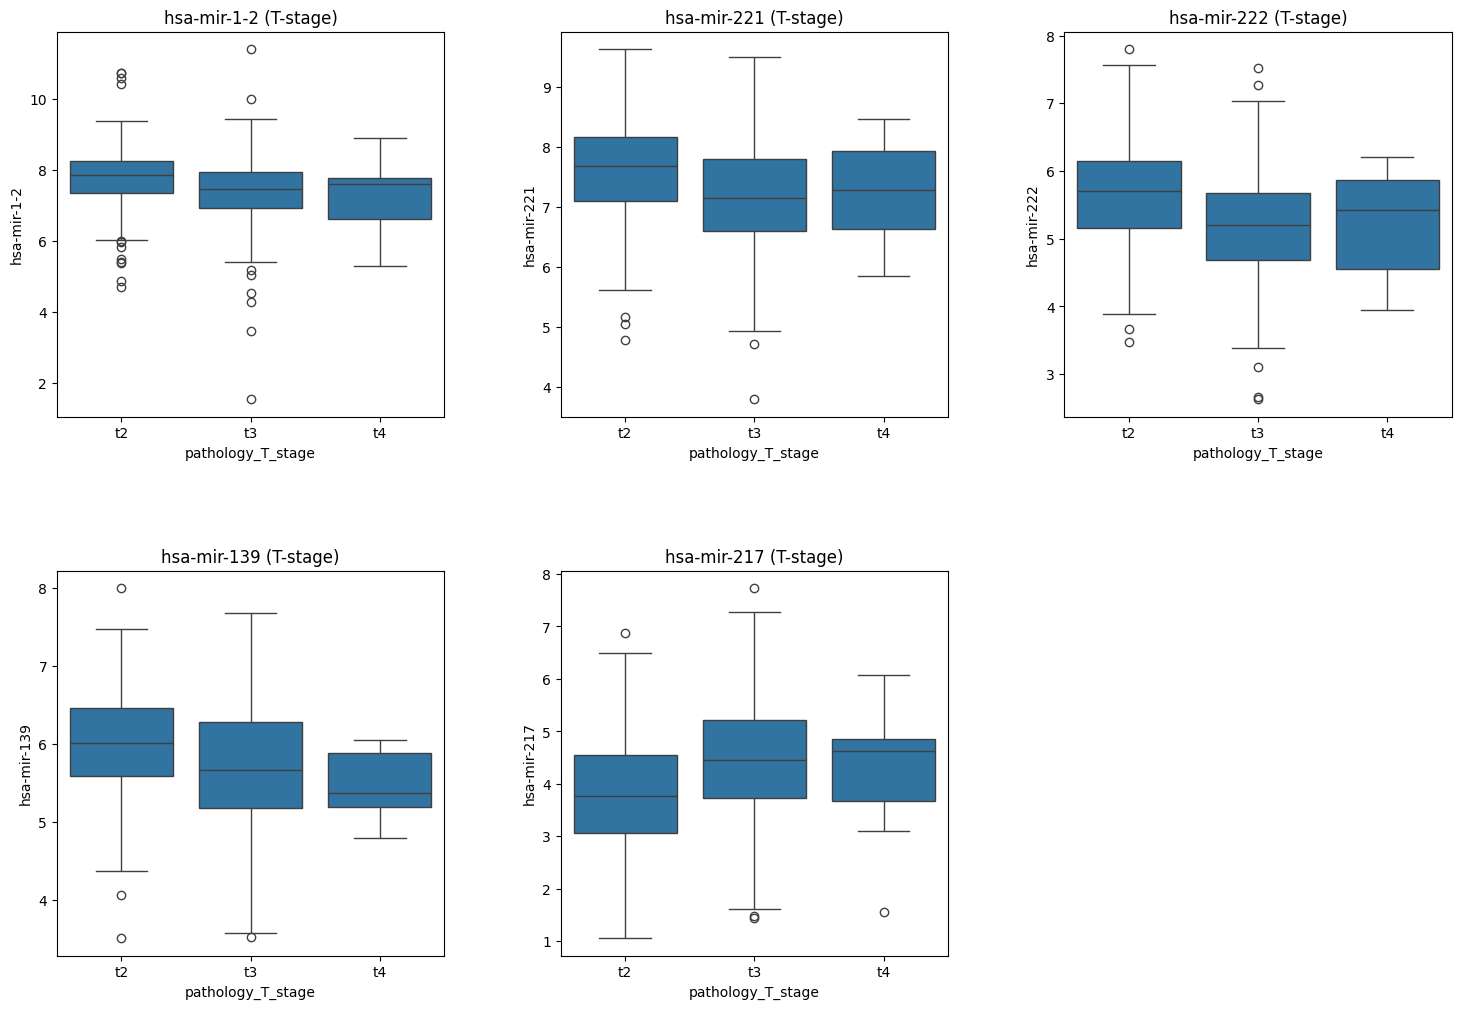

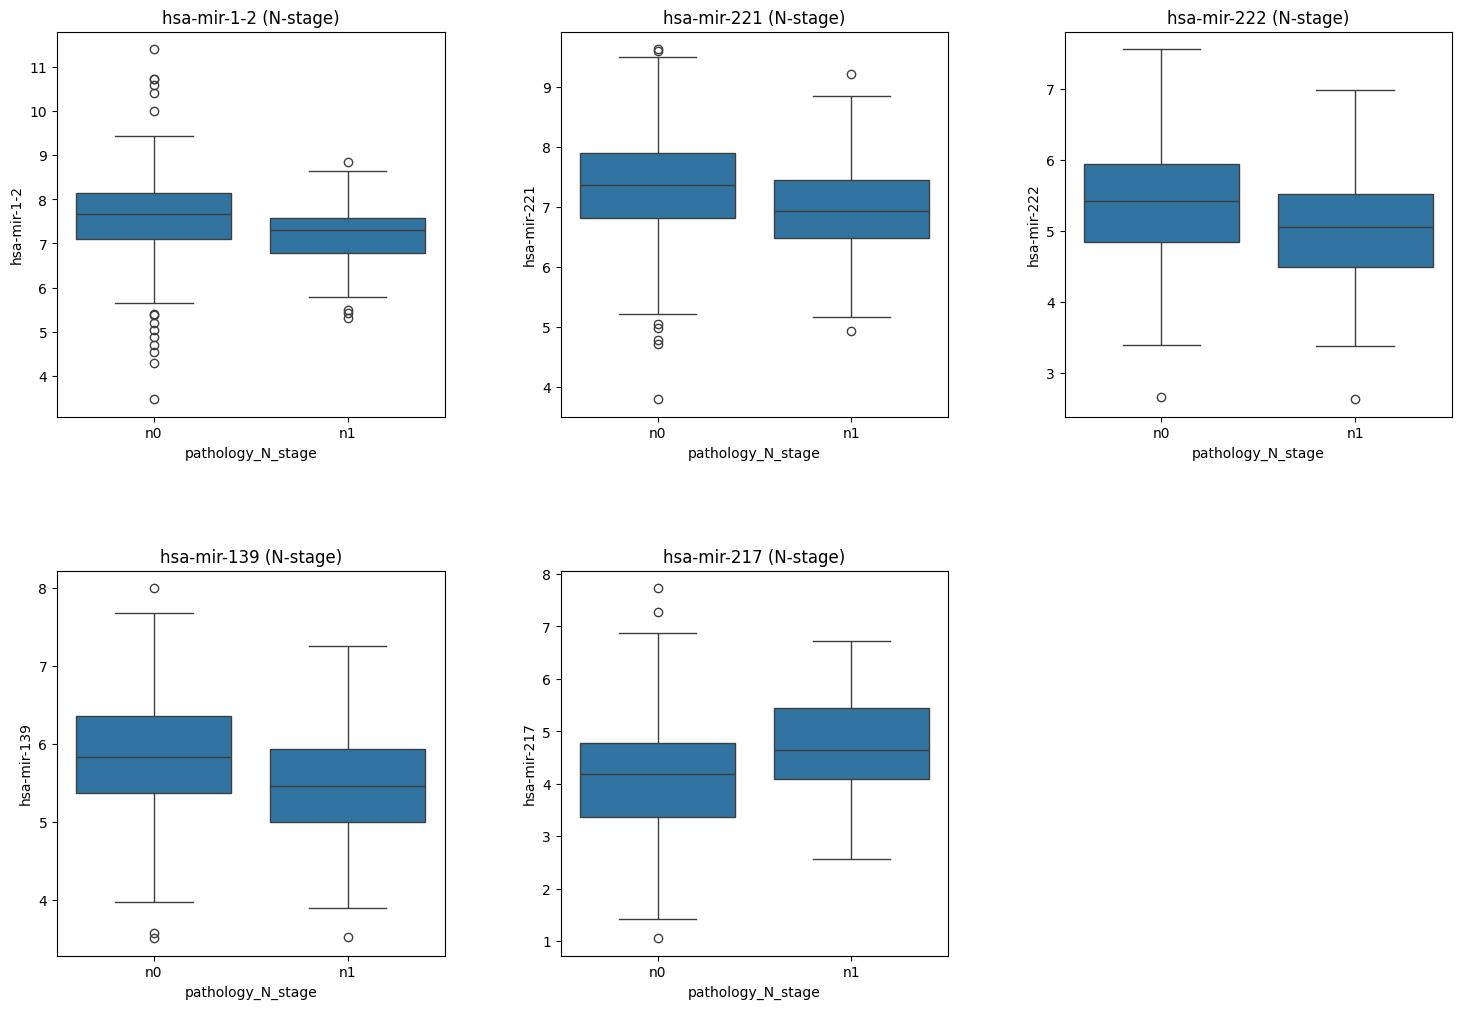

In [36]:
# 5. Визуализация
# Топ-10 miRNA
top_mirnas_t = t_stage_significant['miRNA'].head(10).tolist()
top_mirnas_n = n_stage_significant['miRNA'].head(10).tolist()
top_mirnas_s = survival_corr_significant['miRNA'].head(10).tolist()
top_mirnas = list(set(top_mirnas_t + top_mirnas_n + top_mirnas_s))

# Boxplot для T-stage
plt.figure(figsize=(18, 12))
for i, mirna in enumerate(top_mirnas[:5], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='pathology_T_stage', y=mirna, data=mirna_data[mirna_data['pathology_T_stage'].isin(['t2', 't3', 't4'])])
    plt.title(f'{mirna} (T-stage)', fontsize=12)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

# Boxplot для N-stage
plt.figure(figsize=(18, 12))
for i, mirna in enumerate(top_mirnas[:5], 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='pathology_N_stage', y=mirna, data=mirna_data[mirna_data['pathology_N_stage'].isin(['n0', 'n1'])])
    plt.title(f'{mirna} (N-stage)', fontsize=12)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()


Проверка NaN в overall_survival:
3 пропущенных значений
Образцов после удаления NaN: 491
vital_status отсутствует, предполагаем все события наблюдаемыми


<ipython-input-38-4f9a25fa1c09>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  km_data['event'] = 1  # Если нет vital_status, считаем все события наблюдаемыми
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warnings.warn(warning_text, UserWarning)
/usr/local/lib/python3.11/dist-packages/lifelines/utils/__init__.py:1185: UserWarning: Attempting to convert an unexpected datatype 'object' to float. Suggestion: 1) use `lifelines.utils.datetimes_to_durations` to do conversions or 2) manually convert to floats/booleans.
  warni

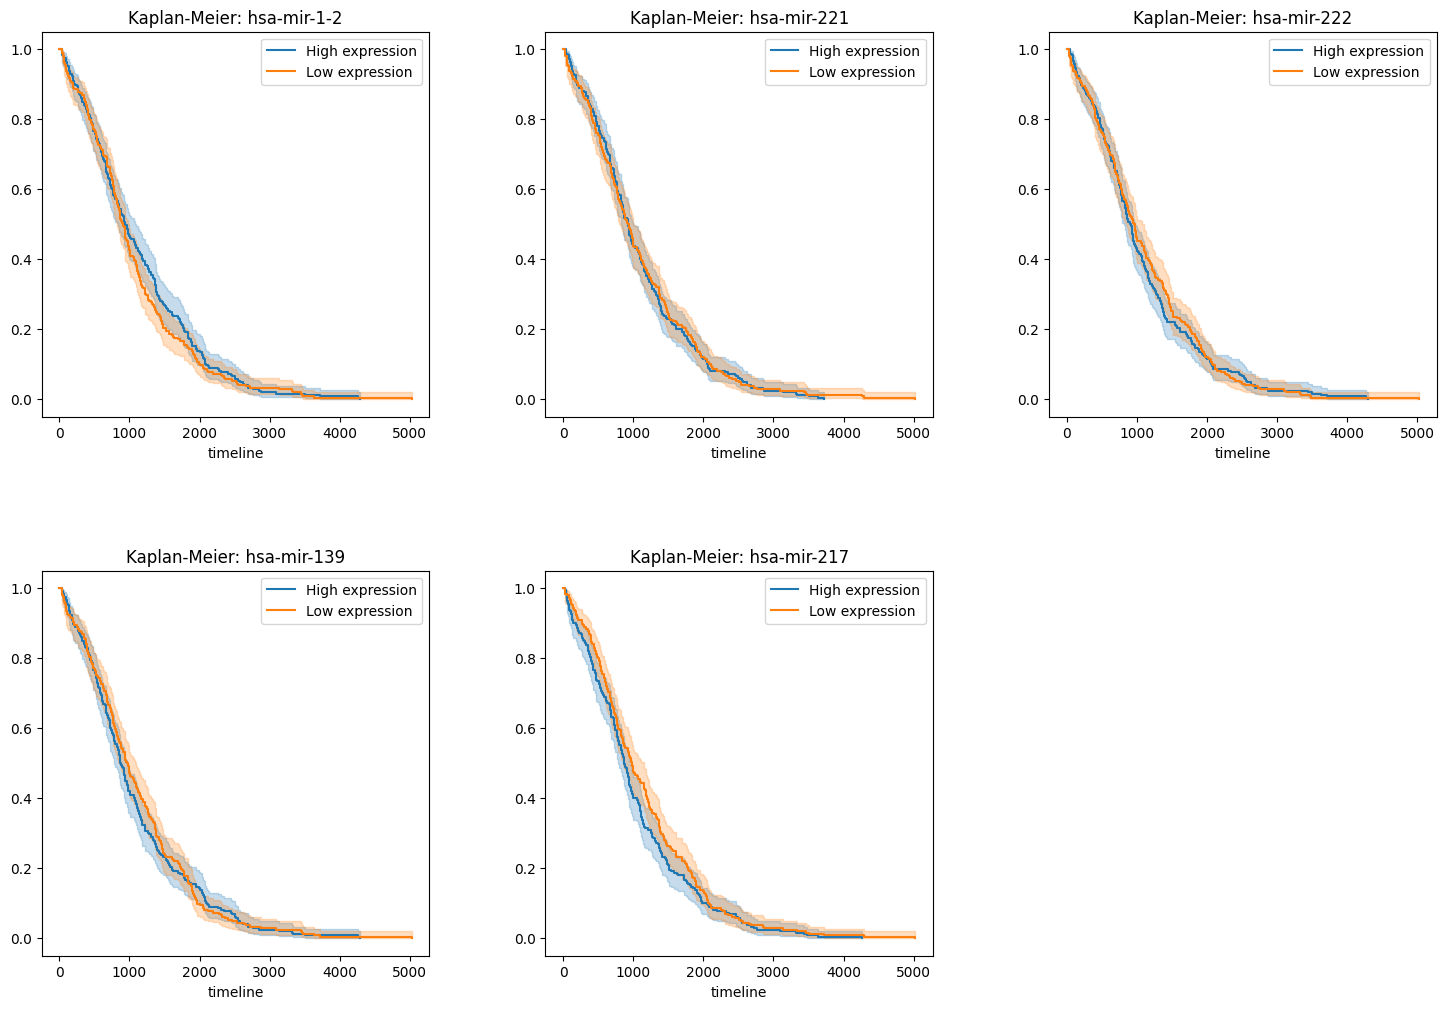

In [38]:
# Kaplan-Meier анализ для топ-5 miRNA по overall_survival
kmf = KaplanMeierFitter()
plt.figure(figsize=(18, 12))

# Проверка наличия NaN в overall_survival
print("\nПроверка NaN в overall_survival:")
print(mirna_data['overall_survival'].isnull().sum(), "пропущенных значений")

# Удаляем строки с NaN в overall_survival
km_data = mirna_data.dropna(subset=['overall_survival'])
print(f"Образцов после удаления NaN: {len(km_data)}")

# Проверяем наличие vital_status (если есть)
if 'vital_status' in km_data.columns:
    print("Используется vital_status для событий")
    event_col = 'vital_status'  # 1 — умер, 0 — жив (цензурирован)
else:
    print("vital_status отсутствует, предполагаем все события наблюдаемыми")
    km_data['event'] = 1  # Если нет vital_status, считаем все события наблюдаемыми
    event_col = 'event'

for i, mirna in enumerate(top_mirnas[:5], 1):
    plt.subplot(2, 3, i)

    # Разделяем на группы по медиане экспрессии
    median_exp = km_data[mirna].median()
    high_exp = km_data[mirna] > median_exp
    low_exp = km_data[mirna] <= median_exp

    # Выживаемость для группы с высокой экспрессией
    kmf.fit(durations=km_data[high_exp]['overall_survival'],
            event_observed=km_data[high_exp][event_col],
            label='High expression')
    kmf.plot(ax=plt.gca())

    # Выживаемость для группы с низкой экспрессией
    kmf.fit(durations=km_data[low_exp]['overall_survival'],
            event_observed=km_data[low_exp][event_col],
            label='Low expression')
    kmf.plot(ax=plt.gca())

    plt.title(f'Kaplan-Meier: {mirna}', fontsize=12)
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plt.show()

<Figure size 1800x1200 with 0 Axes>

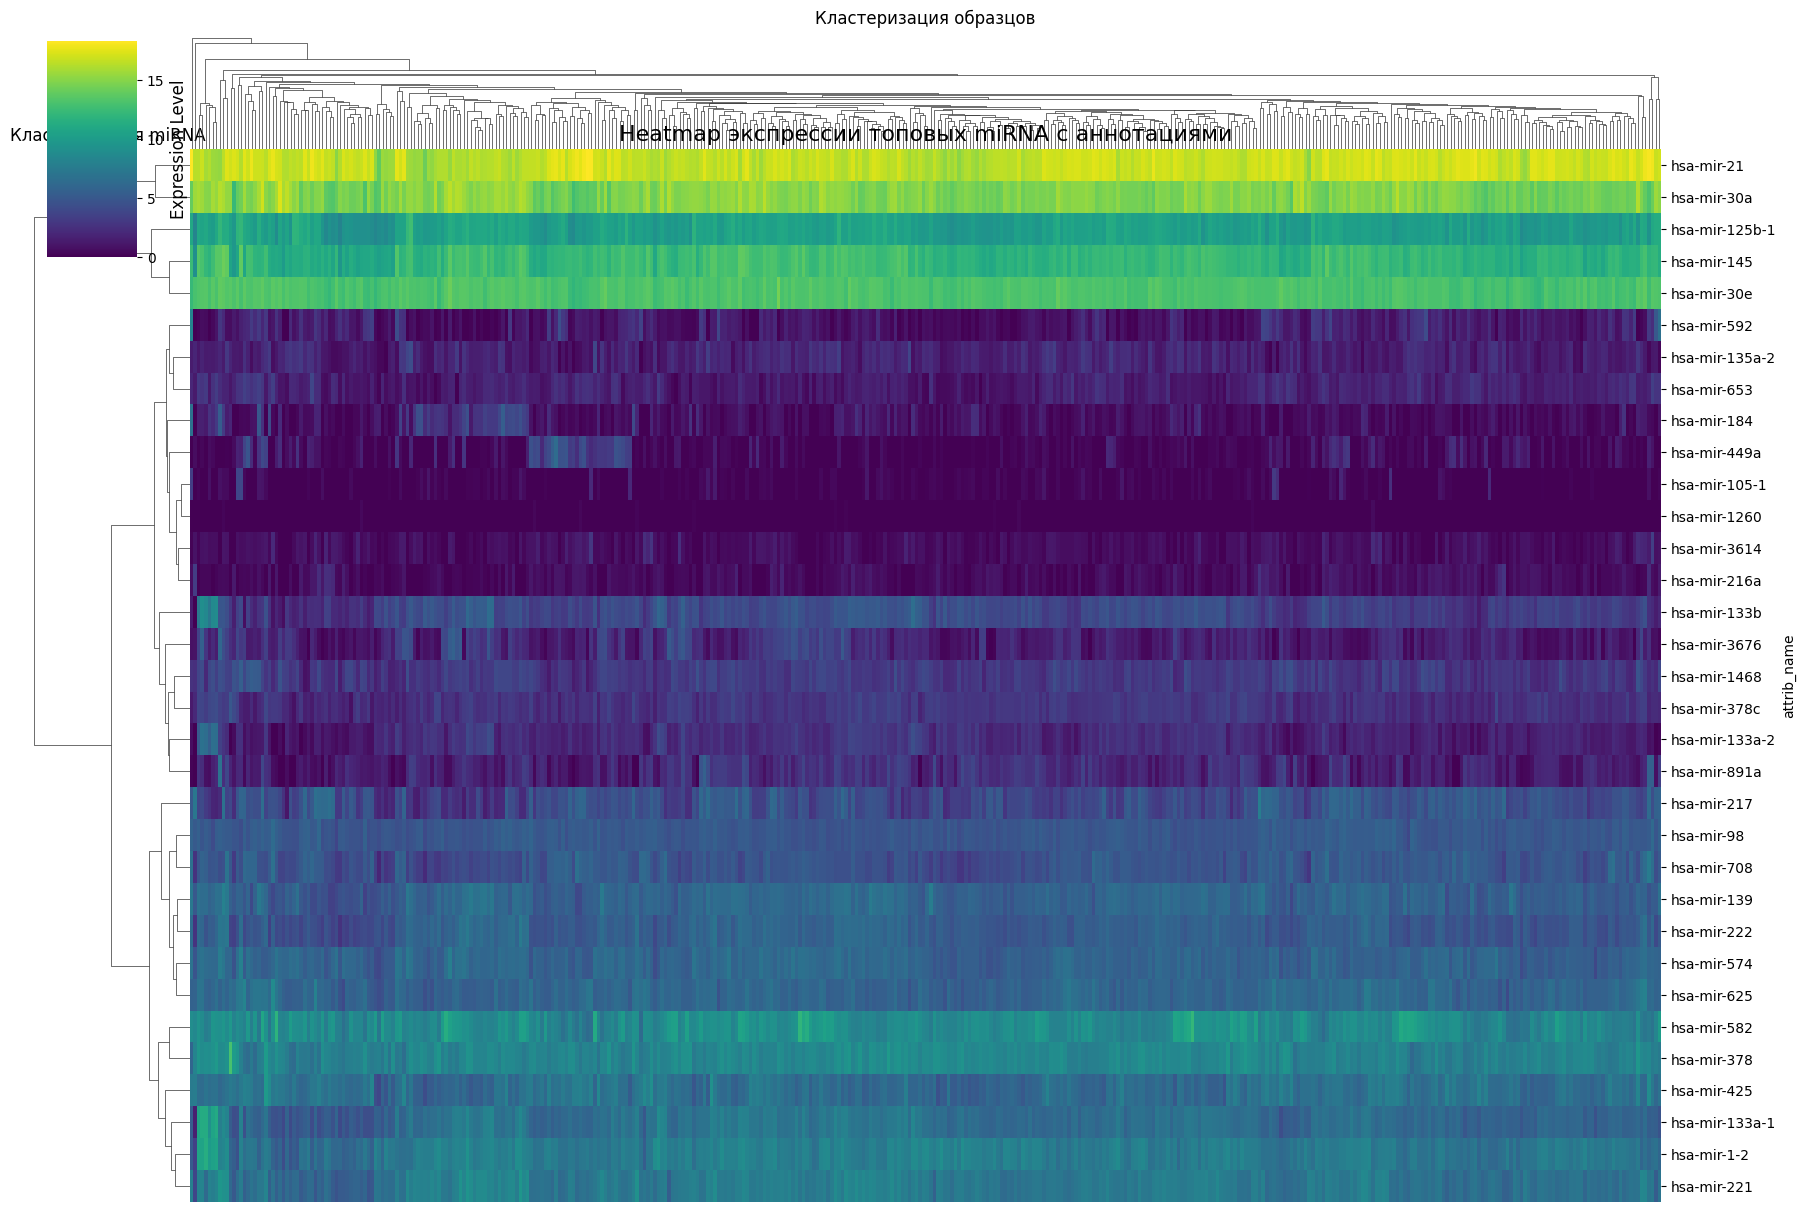

In [37]:
# 6. Улучшенная тепловая карта для топовых miRNA
# Выбираем топ-50 miRNA для большей информативности (или все значимые)
top_mirnas_all = list(set(t_stage_significant['miRNA'].head(25).tolist() +
                          n_stage_significant['miRNA'].head(25).tolist()))

# Фильтруем mirna_data по образцам с полными аннотациями
annotation_df = mirna_data[['pathology_T_stage', 'pathology_N_stage', 'overall_survival']].dropna()
filtered_mirna_data = mirna_data.loc[annotation_df.index]

# Подготовка данных для heatmap
heatmap_data = filtered_mirna_data[top_mirnas_all].T

# Подготовка аннотаций
annotation_df = annotation_df[['pathology_T_stage', 'pathology_N_stage']].astype(str)

# Создаём clustermap
plt.figure(figsize=(18, 12))
g = sns.clustermap(heatmap_data,
                   cmap='viridis',
                   figsize=(18, 12),  # Увеличиваем размер
                   row_cluster=True,  # Кластеризация строк (miRNA)
                   col_cluster=True,  # Кластеризация столбцов (образцы)
                   xticklabels=False,  # Отключаем метки образцов для читаемости
                   yticklabels=True,  # Включаем метки miRNA
                   dendrogram_ratio=0.1,  # Уменьшаем размер дендрограммы
                   cbar_pos=(0.02, 0.8, 0.05, 0.18))  # Позиция цветовой шкалы

# Добавляем цветовую аннотацию для T-stage и N-stage
col_colors = pd.get_dummies(annotation_df[['pathology_T_stage', 'pathology_N_stage']]).iloc[:, [0, 1, 3]]  # Пример для T2, T3/T4, n0, n1
g.ax_heatmap.set_title('Heatmap экспрессии топовых miRNA с аннотациями', fontsize=16)
g.ax_col_dendrogram.set_title('Кластеризация образцов')
g.ax_row_dendrogram.set_title('Кластеризация miRNA')

# Настраиваем цветовую шкалу
g.cax.set_ylabel('Expression Level', fontsize=12)  # Исправлено: g.cbar -> g.cax

plt.show()

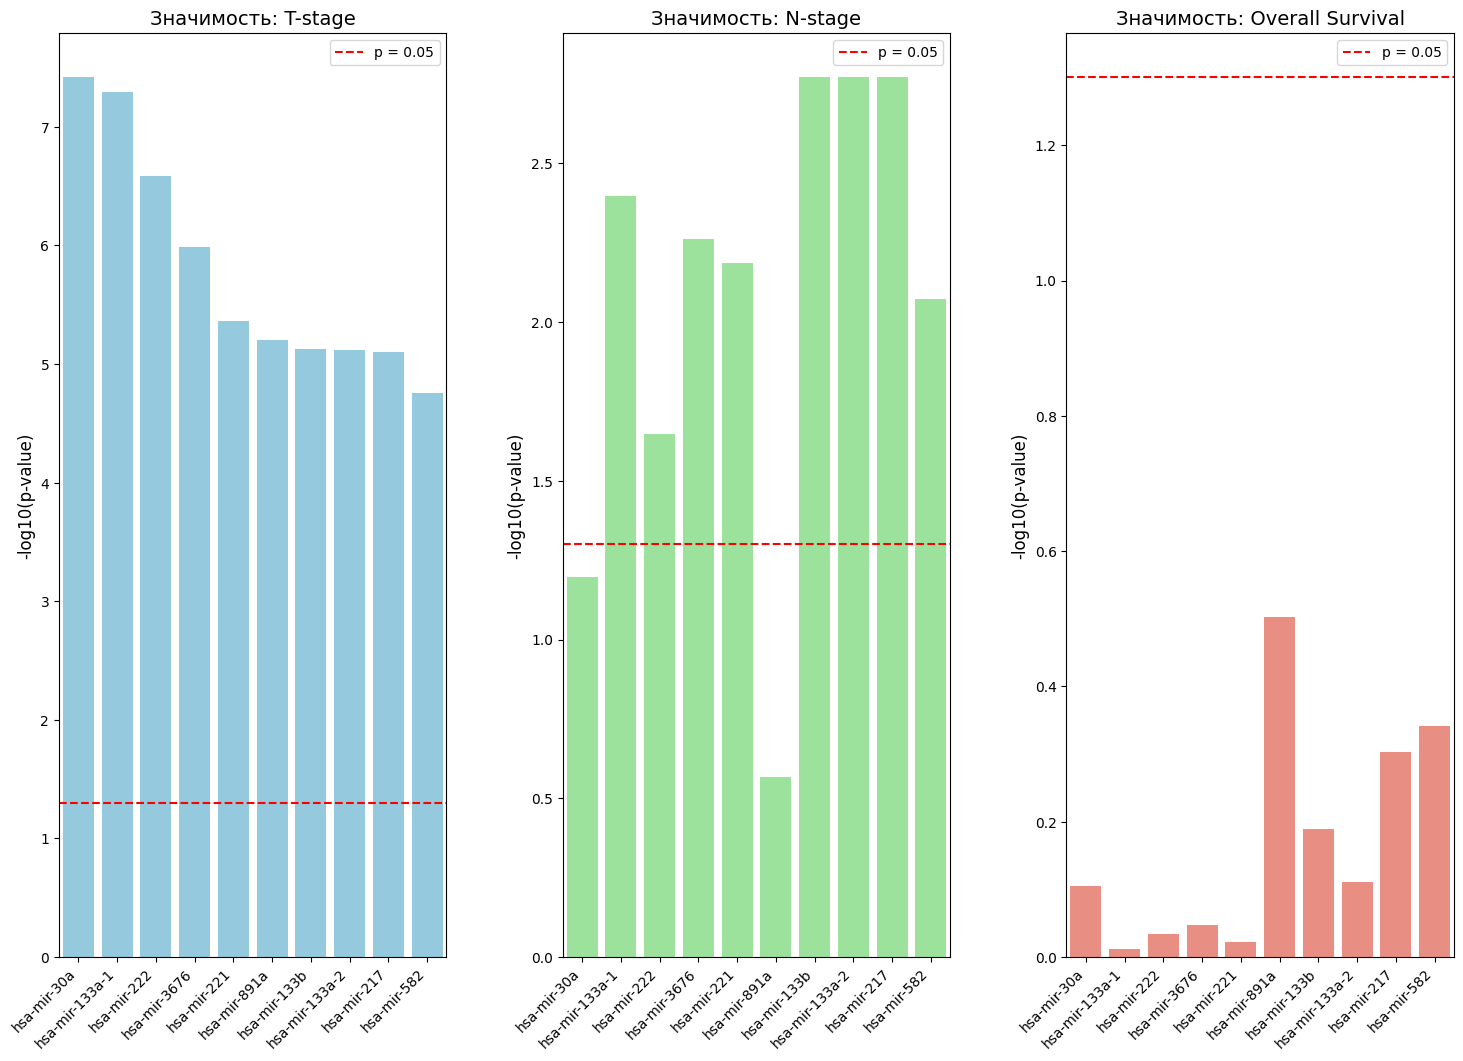

In [39]:
# 7. График p-value для топ-10 miRNA
# Выбираем топ-10 miRNA из объединённого списка кандидатов
top_candidates = candidates_df.head(10).index.tolist()

# Извлекаем p-value для этих miRNA
p_values_data = candidates_df.loc[top_candidates, ['p_value_T_stage', 'p_value_N_stage', 'p_value_survival']]

# Преобразуем p-value в -log10(p-value) для визуализации
p_values_log = -np.log10(p_values_data.fillna(1e-10).clip(lower=1e-10))

# Создаём фигуру с тремя подграфиками
plt.figure(figsize=(18, 12))

# 1. p-value для T-stage
plt.subplot(1, 3, 1)
sns.barplot(x=top_candidates, y=p_values_log['p_value_T_stage'], color='skyblue')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.title('Значимость: T-stage', fontsize=14)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend()

# 2. p-value для N-stage
plt.subplot(1, 3, 2)
sns.barplot(x=top_candidates, y=p_values_log['p_value_N_stage'], color='lightgreen')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.title('Значимость: N-stage', fontsize=14)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend()

# 3. p-value для overall_survival
plt.subplot(1, 3, 3)
sns.barplot(x=top_candidates, y=p_values_log['p_value_survival'], color='salmon')
plt.axhline(y=-np.log10(0.05), color='red', linestyle='--', label='p = 0.05')
plt.title('Значимость: Overall Survival', fontsize=14)
plt.ylabel('-log10(p-value)', fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.legend()

# Настраиваем расстояние между графиками
plt.subplots_adjust(wspace=0.3)

plt.show()